In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


### Setp 1
- Install req libs and Load the datas

In [2]:
import numpy as np
import pandas as pd

In [3]:
data_dir = '/kaggle/input/new-york-city-taxi-fare-prediction/'

In [4]:
!ls -lh {data_dir}

total 5.4G
-rw-r--r-- 1 nobody nogroup  486 Mar 31 07:05 GCP-Coupons-Instructions.rtf
-rw-r--r-- 1 nobody nogroup 336K Mar 31 07:05 sample_submission.csv
-rw-r--r-- 1 nobody nogroup 960K Mar 31 07:05 test.csv
-rw-r--r-- 1 nobody nogroup 5.4G Mar 31 07:07 train.csv


All the data is in the **train.csv** file

In [5]:
# this will take too much tine
# !wc -l {data_dir}/train.csv

In [6]:
!wc -l {data_dir}/test.csv

9914 /kaggle/input/new-york-city-taxi-fare-prediction//test.csv


Getting the first line of the dataset using the _shell_ command

In [7]:
!head {data_dir}/train.csv

In [8]:
!head {data_dir}/test.csv

fare amount is missingw which is the pratical Target column for our analysis

#### Loading
Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the key column
- Parse pickup datetime while loading data
- Specify data types for other columns
    - float32 for geo coordinates
    - float32 for fare amount
    - uint8 for passenger count
- Work with a 1% sample of the data (~500k rows)

In [9]:
# Taking all the columns except the keys
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
selected_cols

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [10]:
d_types = {
    'fare_amount' : 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude' : 'float32',
    'passenger_count' : 'uint8',
}
d_types

{'fare_amount': 'float32',
 'pickup_longitude': 'float32',
 'pickup_latitude': 'float32',
 'dropoff_longitude': 'float32',
 'dropoff_latitude': 'float32',
 'passenger_count': 'uint8'}

In [11]:
import random as rnd
sample_fraction = 0.03
rnd.seed(42)

def skip_row(row_idx) :
#     If this functon retrun false then the number is going to be in data
    if row_idx == 0 :
        return False
    return rnd.random() >= sample_fraction

In [12]:
%%time
data = pd.read_csv(data_dir + '/train.csv', 
                   usecols = selected_cols, 
                   dtype = d_types, 
                   parse_dates= ['pickup_datetime'], 
                   skiprows = skip_row) # A function is passed as a prameter

CPU times: user 2min, sys: 5.56 s, total: 2min 5s
Wall time: 2min 52s


In [13]:
data.sample(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
304580,5.7,2012-06-12 13:28:11+00:00,-73.968346,40.755043,-73.978638,40.741177,2
666328,8.5,2014-08-03 22:43:00+00:00,-73.964485,40.764507,-73.982224,40.764454,1
904519,8.1,2010-04-12 11:04:00+00:00,-73.981400,40.767948,-73.961098,40.777576,1
1547619,7.0,2013-10-25 08:53:30+00:00,-73.953934,40.766937,-73.963173,40.775150,1
35453,16.5,2013-03-06 19:42:06+00:00,-73.963799,40.768436,-74.002052,40.725754,2
268939,8.1,2012-07-04 13:58:00+00:00,-73.984772,40.764439,-73.951553,40.772903,1
1194175,15.5,2012-09-20 03:01:00+00:00,-74.008377,40.704796,-73.994766,40.755188,1
1323576,5.7,2010-09-28 20:26:00+00:00,-73.987419,40.750629,-73.995934,40.759060,1
919648,7.7,2010-04-17 19:07:03+00:00,-73.973274,40.757526,-73.983742,40.757526,2
865873,14.0,2013-01-24 09:10:17+00:00,-73.975243,40.752380,-74.007088,40.727108,1


Here I am trying with 1% if the data, We can also try this using _3%, 10%, 50% and even 100%_ of the data

In [14]:
test_data = pd.read_csv(data_dir + '/test.csv', dtype= d_types, parse_dates = ['pickup_datetime'])
test_data.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


### Exploring the data

- basic info about training and test set
- EDA and viz
- Ask and Answer the questions

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661731 entries, 0 to 1661730
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   fare_amount        1661731 non-null  float32            
 1   pickup_datetime    1661731 non-null  datetime64[ns, UTC]
 2   pickup_longitude   1661731 non-null  float32            
 3   pickup_latitude    1661731 non-null  float32            
 4   dropoff_longitude  1661717 non-null  float32            
 5   dropoff_latitude   1661717 non-null  float32            
 6   passenger_count    1661731 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 46.0 MB


In [17]:
data.shape

(1661731, 7)

In [18]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.661731e+06,1.661731e+06,1.661731e+06,1.661717e+06,1.661717e+06,1.661731e+06
mean,1.135368e+01,-7.250970e+01,3.991889e+01,-7.251003e+01,3.991955e+01,1.685489e+00
std,9.836679e+00,1.282921e+01,1.052012e+01,1.306792e+01,1.029647e+01,1.328315e+00
min,-3.000000e+02,-3.439245e+03,-3.474112e+03,-3.367929e+03,-3.474112e+03,0.000000e+00
25%,6.000000e+00,-7.399203e+01,4.073491e+01,-7.399140e+01,4.073399e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075266e+01,-7.398017e+01,4.075313e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076711e+01,-7.396368e+01,4.076806e+01,2.000000e+00
max,1.097480e+03,3.442185e+03,3.347260e+03,3.442185e+03,3.351403e+03,2.080000e+02


In [19]:
data.pickup_datetime.min(), data.pickup_datetime.max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

In [20]:
test_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


The data is not cleaned as -1000 Latitude does not exist and also _208_ pasengers are can't ride a Taxi

#### Observations
- 550K+ data
- No missing data (in sample)
- Fare ranges from -52 to 499
- Pasengers from 0 to 208
- Seems to be error in the latitue and logitude
- Dates Ranges from 1st Jan 2009 to 30th June 2015

Need to deal with the outliares and preproces the data.

In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [22]:
test_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [23]:
test_data.pickup_datetime.min(), test_data.pickup_datetime.max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

Training data is Clean we can refer to the taining data for the purpost of clenaing the data.

Like we can remove the columns whose values lies outside the Training data.

## Exploratory Data Analysis

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

Skipping for Now -> Following the content of the Video This will be done a bit later when working properly

In [25]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.661731e+06,1.661731e+06,1.661731e+06,1.661717e+06,1.661717e+06,1.661731e+06
mean,1.135368e+01,-7.250970e+01,3.991889e+01,-7.251003e+01,3.991955e+01,1.685489e+00
std,9.836679e+00,1.282921e+01,1.052012e+01,1.306792e+01,1.029647e+01,1.328315e+00
min,-3.000000e+02,-3.439245e+03,-3.474112e+03,-3.367929e+03,-3.474112e+03,0.000000e+00
25%,6.000000e+00,-7.399203e+01,4.073491e+01,-7.399140e+01,4.073399e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075266e+01,-7.398017e+01,4.075313e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076711e+01,-7.396368e+01,4.076806e+01,2.000000e+00
max,1.097480e+03,3.442185e+03,3.347260e+03,3.442185e+03,3.351403e+03,2.080000e+02


<Axes: >

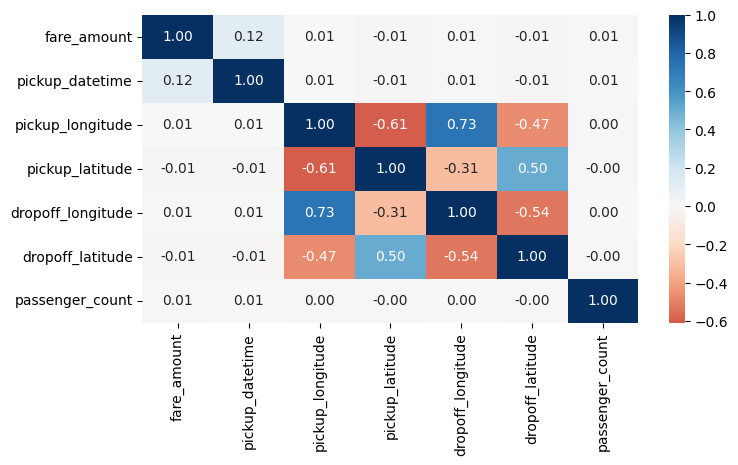

In [26]:
plt.figure(figsize=(8,4))
sns.heatmap(data.corr(), cmap = 'RdBu', annot= True, fmt = '.2f', center = 0)

This is going to be a bad model if we diretly use the columns without fearure Engineering

### Preparing the Dataset for training
- Split it into the training and validation set
- Fill/Remove Missing values
- Extrarct Input and Output
    - Training
    - Validation
    - Test

#### Splitting the dataset

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train, val = train_test_split(data, test_size = 0.2, random_state = len(data))
len(train), len(val)

(1329384, 332347)

In [29]:
train.shape

(1329384, 7)

In [30]:
# Dropping the missing values
train = train.dropna()
val = val.dropna()

train.shape, val.shape

((1329373, 7), (332344, 7))

Sepraing the inputs and output cols

In [31]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

We can't Train a a model on date time column we need to convert the date time to multiple columns by extraicting the values

In [32]:
input_col = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
tar_col = 'fare_amount'

In [33]:
x_train = train[input_col].copy()
y_train = train[tar_col].copy()

x_val = val[input_col].copy()
y_val = val[tar_col].copy()

x_train.shape, y_val.shape

((1329373, 5), (332344,))

## Hardcoded and baseline Models

Making some of the very simple models which produce very dumb results and compare the models to the This to know the status
and perfoming efficieny of the modle

In [34]:
# Using Classes to make it similar to the SK-learn models

class MeanRegressor:
    def fit(self, inputs, targets):
        self.mean = targets.mean()
        return self
    
    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)
    

In [35]:
model = MeanRegressor().fit(x_train, y_train)

In [36]:
model.mean

11.34721

In [37]:
train_pre = model.predict(x_train)

### Evaluating 
using RMSE for the evaluating the error

In [38]:
from sklearn.metrics import mean_squared_error

def rmse(inp, tar):
    return mean_squared_error(inp, tar, squared=False)

In [39]:
train_rmse = rmse(train_pre, y_train)
train_rmse

9.772153

A very high error in predicting the rate

In [40]:
val_rmse = rmse(model.predict(x_val), y_val)
val_rmse

10.090788

### Train and Evaluate Base line Models

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
model = LinearRegression().fit(x_train, y_train)

In [43]:
train_pre = model.predict(x_train)
train_pre

array([11.461119, 11.274023, 11.367463, ..., 11.273888, 11.273955,
       11.461076], dtype=float32)

In [44]:
train_rmse = rmse(train_pre, y_train)
train_rmse

9.77105

In [45]:
model.coef_

array([-0.00091909, -0.00328569,  0.00589195,  0.00096536,  0.09349196],
      dtype=float32)

In [46]:
val_pre = model.predict(x_val)
val_rmse = rmse(val_pre, y_val)
val_rmse

10.089108

Not at all a good model -> almost equal to the hardcoded model

The main reason for this is Taining data have geo-coordinates, which is not in a format useful for the model and we are not using the one of the most imp column : pickup date and time

In [47]:
test_data

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


In [48]:
sub_df = pd.read_csv(data_dir + '/sample_submission.csv')
sub_df.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [49]:
def submission(model, test_data, filename):
    pre_test = model.predict(test_data)
    print(pre_test)
    sub_df.fare_amount = pre_test
    sub_df.to_csv(filename, index = None)
#     print(sub_df)

In [50]:
# Skipping downloading the file for now
# submission(model, test_data[input_col], "LinReg_predection.csv")

#### Removing the outliares

- fare_amount : 1 to 500
- long : -75 to -72
- lat : 40 to 42
- passenger : 1 to 6

In [51]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [52]:
train.shape, val.shape, test_data.shape

((1329373, 7), (332344, 7), (9914, 7))

In [53]:
def remove_out(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [54]:
train = remove_out(train)
val = remove_out(val)

train.shape, val.shape, test_data.shape

((1296679, 7), (324204, 7), (9914, 7))

### Feature Engineering

- Extract parts of date
- Remove outliares
- Add dist b/w Pickup and drop
- Add dist from landmarks

#### Extracting parts form date

In [55]:
def add_date_parts (df, col) :
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [56]:
input_col

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [57]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
325026,8.5,2012-12-17 21:49:00+00:00,-73.991852,40.684742,-73.972855,40.677658,3
1193429,5.0,2014-06-06 21:47:00+00:00,-73.972366,40.745384,-73.967659,40.755035,1
1351064,7.3,2010-05-06 14:51:50+00:00,-73.947533,40.808662,-73.947540,40.817768,2
162480,10.0,2013-03-06 22:40:32+00:00,-73.983925,40.773552,-73.964882,40.753300,2
1032173,4.9,2010-10-23 10:33:20+00:00,-73.998161,40.728954,-74.006630,40.729092,2


In [58]:
add_date_parts(train,'pickup_datetime')
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
325026,8.5,2012-12-17 21:49:00+00:00,-73.991852,40.684742,-73.972855,40.677658,3,2012,12,17,0,21
1193429,5.0,2014-06-06 21:47:00+00:00,-73.972366,40.745384,-73.967659,40.755035,1,2014,6,6,4,21
1351064,7.3,2010-05-06 14:51:50+00:00,-73.947533,40.808662,-73.947540,40.817768,2,2010,5,6,3,14
162480,10.0,2013-03-06 22:40:32+00:00,-73.983925,40.773552,-73.964882,40.753300,2,2013,3,6,2,22
1032173,4.9,2010-10-23 10:33:20+00:00,-73.998161,40.728954,-74.006630,40.729092,2,2010,10,23,5,10


In [59]:
add_date_parts(val, 'pickup_datetime')
val.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
445623,15.7,2011-03-18 20:05:00+00:00,-73.955383,40.764061,-73.996735,40.723850,2,2011,3,18,4,20
1458920,7.5,2015-05-19 06:58:07+00:00,-73.989815,40.756699,-73.984100,40.769711,1,2015,5,19,1,6
889073,4.5,2012-02-08 17:54:00+00:00,-73.959480,40.767353,-73.964714,40.759151,1,2012,2,8,2,17
1305343,8.1,2012-08-11 19:20:00+00:00,-73.959465,40.809738,-73.980309,40.782291,4,2012,8,11,5,19
1153554,7.3,2009-07-04 12:51:00+00:00,-73.964905,40.755657,-73.978409,40.772228,1,2009,7,4,5,12


In [60]:
add_date_parts(test_data, 'pickup_datetime')
test_data.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21


#### Distance b/w pickup and drop locations

We are going to use the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) for the Calculation of the Distance between 2 coordinate in the map

Directly taking the function and copying it online.

In [61]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return c
#     km = 6367 * c
#     return km


In [62]:
def add_dist(df) :
    df['distance'] = haversine_np(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_longitude)

In [63]:
add_dist(train)
add_dist(val)
add_dist(test_data)

In [64]:
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,distance
325026,8.5,2012-12-17 21:49:00+00:00,-73.991852,40.684742,-73.972855,40.677658,3,2012,12,17,0,21,2.001153
1193429,5.0,2014-06-06 21:47:00+00:00,-73.972366,40.745384,-73.967659,40.755035,1,2014,6,6,4,21,2.002120
1351064,7.3,2010-05-06 14:51:50+00:00,-73.947533,40.808662,-73.947540,40.817768,2,2010,5,6,3,14,2.002874
162480,10.0,2013-03-06 22:40:32+00:00,-73.983925,40.773552,-73.964882,40.753300,2,2013,3,6,2,22,2.002563
1032173,4.9,2010-10-23 10:33:20+00:00,-73.998161,40.728954,-74.006630,40.729092,2,2010,10,23,5,10,2.002514


#### Distance form popular landmarks

popular land marks : 
- JFK airport
- LGA Airport
- EWR Airport
- Times Square
- Met Meuseum
- WTC
- Statue of Liberty
- Empire state

In [65]:
jfk_longlat = -73.7797, 40.6446
lga_longlat = -73.8718, 40.7733
ewa_longlat = -74.1745, 40.6895

times_longlat = -73.985130, 40.758896
met_longlat = -73.9632, 40.7794
wtc_longlat = -74.013382, 40.712742

liberty_longlat = -74.0445, 40.6892
esb_longlat = -73.9857, 40.7484

In [66]:
def add_landmark_drop_dist(df, landmark, landmark_longlat):
    lon, lat = landmark_longlat
    df[landmark + '_drop_dist'] = haversine_np(lon, lat, df.dropoff_longitude, df.dropoff_latitude)
    
def add_landmark_pick_dist(df, landmark, landmark_longlat):
    lon, lat = landmark_longlat
    df[landmark + '_pick_dist'] = haversine_np(lon, lat, df.dropoff_longitude, df.dropoff_latitude)

In [67]:
def add_landmark(df):
    landmarks = [('jfk', jfk_longlat),
                 ('lga', lga_longlat),
                 ('ewa', ewa_longlat),
                 ('times_square', times_longlat),
                 ('met', met_longlat),
                 ('wtc', wtc_longlat),
                 ('esb', esb_longlat),
                 ('liberty', liberty_longlat)]
    for name, longlat in landmarks:
        add_landmark_drop_dist(df, name, longlat)
        # add_landmark_pick_dist(df, name, longlat)

In [68]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'distance'],
      dtype='object')

In [69]:
add_landmark(train)
add_landmark(val)
add_landmark(test_data)

In [70]:
train.columns.tolist()

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'pickup_datetime_year',
 'pickup_datetime_month',
 'pickup_datetime_day',
 'pickup_datetime_weekday',
 'pickup_datetime_hour',
 'distance',
 'jfk_drop_dist',
 'lga_drop_dist',
 'ewa_drop_dist',
 'times_square_drop_dist',
 'met_drop_dist',
 'wtc_drop_dist',
 'esb_drop_dist',
 'liberty_drop_dist']

In [71]:
train

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,...,pickup_datetime_hour,distance,jfk_drop_dist,lga_drop_dist,ewa_drop_dist,times_square_drop_dist,met_drop_dist,wtc_drop_dist,esb_drop_dist,liberty_drop_dist
325026,8.5,2012-12-17 21:49:00+00:00,-73.991852,40.684742,-73.972855,40.677658,3,2012,12,17,...,21,2.001153,0.002622,0.002138,0.002677,0.001427,0.001780,0.000814,0.001246,0.000969
1193429,5.0,2014-06-06 21:47:00+00:00,-73.972366,40.745384,-73.967659,40.755035,1,2014,6,6,...,21,2.002120,0.003146,0.001307,0.002965,0.000241,0.000429,0.000954,0.000265,0.001534
1351064,7.3,2010-05-06 14:51:50+00:00,-73.947533,40.808662,-73.947540,40.817768,2,2010,5,6,...,14,2.002874,0.003750,0.001266,0.003744,0.001141,0.000701,0.002029,0.001312,0.002584
162480,10.0,2013-03-06 22:40:32+00:00,-73.983925,40.773552,-73.964882,40.753300,2,2013,3,6,...,22,2.002563,0.003099,0.001279,0.002988,0.000285,0.000456,0.000955,0.000288,0.001536
1032173,4.9,2010-10-23 10:33:20+00:00,-73.998161,40.728954,-74.006630,40.729092,2,2010,10,23,...,10,2.002514,0.003346,0.001943,0.002326,0.000593,0.001049,0.000299,0.000436,0.000858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901112,12.9,2011-02-06 01:52:22+00:00,-73.958893,40.764137,-73.913765,40.778343,2,2011,2,6,...,1,2.001507,0.002932,0.000562,0.003781,0.001003,0.000654,0.001745,0.001085,0.002326
76956,6.5,2012-06-12 07:56:58+00:00,-73.967865,40.755081,-73.979919,40.739037,1,2012,6,12,...,7,2.002503,0.003120,0.001549,0.002715,0.000353,0.000738,0.000638,0.000180,0.001219
27856,9.3,2012-02-19 22:04:47+00:00,-73.965851,40.800301,-73.961670,40.771187,1,2012,2,19,...,22,2.002974,0.003268,0.001188,0.003155,0.000377,0.000145,0.001228,0.000509,0.001802
801095,5.7,2009-09-05 11:22:00+00:00,-73.987434,40.770462,-73.968651,40.762646,1,2009,9,5,...,11,2.002575,0.003240,0.001294,0.003007,0.000228,0.000301,0.001053,0.000336,0.001628


In [72]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,1296679.0,11.339486,9.694160,1.000000e+00,6.000000,8.500000,12.500000,499.000000
pickup_longitude,1296679.0,-73.975113,0.039111,-7.497809e+01,-73.992249,-73.982094,-73.968338,-72.471581
pickup_latitude,1296679.0,40.751026,0.029987,4.006390e+01,40.736553,40.753365,40.767494,41.787712
dropoff_longitude,1296679.0,-73.974297,0.038416,-7.484308e+01,-73.991608,-73.980629,-73.965347,-72.506775
dropoff_latitude,1296679.0,40.751324,0.033202,4.005421e+01,40.735493,40.753815,40.768341,41.806301
passenger_count,1296679.0,1.690998,1.306651,1.000000e+00,1.000000,1.000000,2.000000,6.000000
pickup_datetime_year,1296679.0,2011.736164,1.865233,2.009000e+03,2010.000000,2012.000000,2013.000000,2015.000000
pickup_datetime_month,1296679.0,6.270983,3.435958,1.000000e+00,3.000000,6.000000,9.000000,12.000000
pickup_datetime_day,1296679.0,15.723326,8.687338,1.000000e+00,8.000000,16.000000,23.000000,31.000000
pickup_datetime_weekday,1296679.0,3.039458,1.950245,0.000000e+00,1.000000,3.000000,5.000000,6.000000


In [73]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
pickup_longitude,9914.0,-73.974716,0.042774,-74.252190,-73.992500,-73.982327,-73.968012,-72.986534
pickup_latitude,9914.0,40.751041,0.033541,40.573143,40.736125,40.753052,40.767113,41.709557
dropoff_longitude,9914.0,-73.973656,0.039072,-74.263245,-73.991249,-73.980015,-73.964062,-72.990967
dropoff_latitude,9914.0,40.751740,0.035435,40.568974,40.735253,40.754065,40.768757,41.696682
passenger_count,9914.0,1.671273,1.278747,1.000000,1.000000,1.000000,2.000000,6.000000
pickup_datetime_year,9914.0,2011.815816,1.803347,2009.000000,2010.000000,2012.000000,2014.000000,2015.000000
pickup_datetime_month,9914.0,6.857979,3.353272,1.000000,4.000000,7.000000,10.000000,12.000000
pickup_datetime_day,9914.0,16.194170,8.838482,1.000000,9.000000,16.000000,25.000000,31.000000
pickup_datetime_weekday,9914.0,2.852834,1.994451,0.000000,1.000000,3.000000,5.000000,6.000000
pickup_datetime_hour,9914.0,13.467420,6.868584,0.000000,8.000000,15.000000,19.000000,23.000000


### Exploring the relaion between the newly created data

<Axes: >

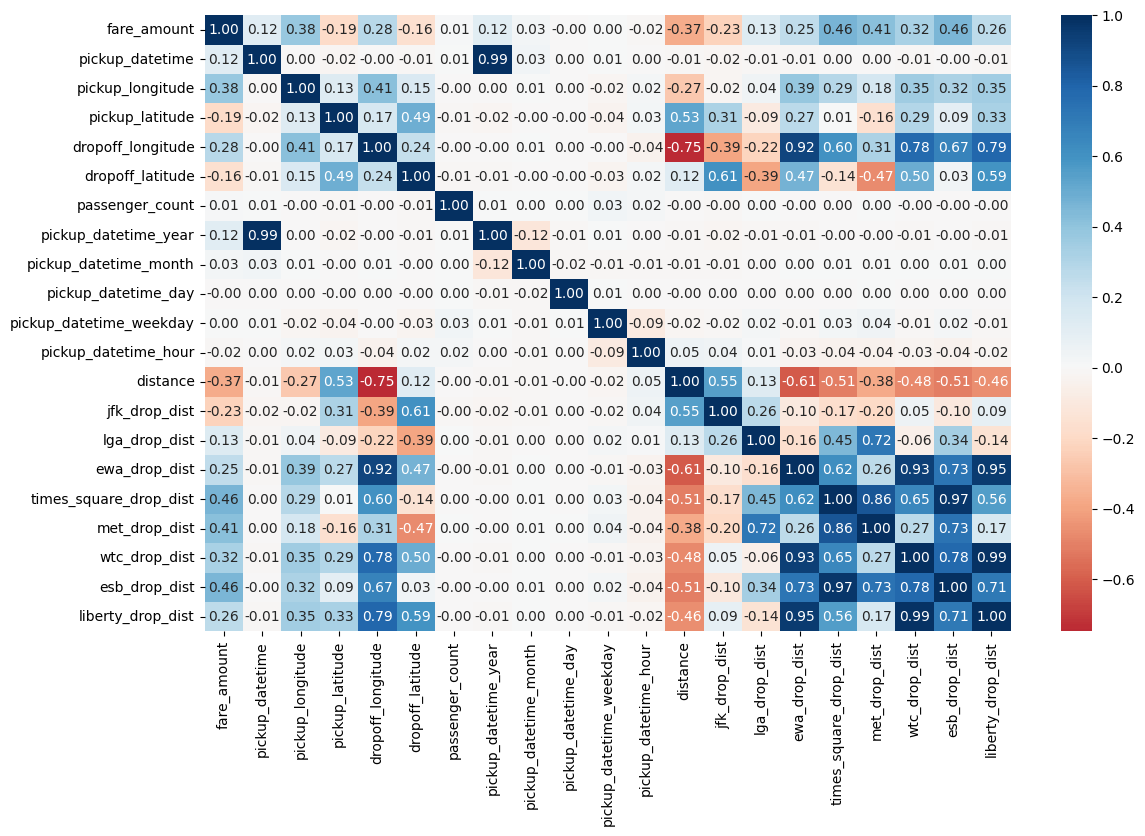

In [74]:
plt.figure(figsize=(13,8))
sns.heatmap(train.corr(), cmap='RdBu', center = 0, annot = True, fmt = '.2f')

Many data like Months, Weekdays can be converted to Categorical Columns for better model, but as of now

### Scaling and One Hot encoding

**Encoding**<br>
skipping this for now as there are no columns treated as Categoricals

In [75]:
from sklearn.preprocessing import StandardScaler

Only considering the recently created columns for the predection

In [76]:
input_col = ['passenger_count', 'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day', 'pickup_datetime_weekday', 'pickup_datetime_hour', 'distance', 'jfk_drop_dist', 'lga_drop_dist', 'ewa_drop_dist', 'times_square_drop_dist', 'met_drop_dist', 'wtc_drop_dist', 'esb_drop_dist', 'liberty_drop_dist']
tar_col = 'fare_amount'

In [77]:
# scaler = StandardScaler().fit(train[input_col])

In [78]:
# train[input_col] = scaler.transform(train[input_col])
# val[input_col] = scaler.transform(val[input_col])
# test_data[input_col] = scaler.transform(test_data[input_col])

## Train and evaluate the models

- Linear regression
- Random Forest
- Gradient Boost
- Ridge Regression

In [79]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'distance',
       'jfk_drop_dist', 'lga_drop_dist', 'ewa_drop_dist',
       'times_square_drop_dist', 'met_drop_dist', 'wtc_drop_dist',
       'esb_drop_dist', 'liberty_drop_dist'],
      dtype='object')

In [80]:
x_train = train[input_col]
y_train = train[tar_col]

x_val = val[input_col]
y_val = val[tar_col]

In [81]:
def evaluate(model):
    train_pre = model.predict(x_train)
    train_rmse = rmse(train_pre, y_train)
    val_pre = model.predict(x_val)
    val_rmse = rmse(val_pre, y_val)
    
    return train_rmse, val_rmse

In [82]:
# .Using Linear Regression
model = LinearRegression().fit(x_train, y_train)
evaluate(model)

(7.765262376004273, 7.822492129730574)

In [83]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

m_name = ['LinReg', 'Ridge', 'Lasso']
models_list = [LinearRegression, Ridge, Lasso]

for i in range(len(models_list)):
    model = models_list[i]().fit(x_train, y_train)
    print(m_name[i], "\t:\t", evaluate(model))

LinReg 	:	 (7.765262376004273, 7.822492129730574)
Ridge 	:	 (8.507106660253534, 8.590810801591186)
Lasso 	:	 (9.64360746904017, 9.734711661355728)


In [84]:
# Uaing Radnom Foresr
# %%time
from sklearn.ensemble import RandomForestRegressor
model  = RandomForestRegressor(random_state = len(x_train), n_jobs = -1, max_depth = 10, n_estimators = 100, max_leaf_nodes = 500).fit(x_train, y_train)
print("Random Forest \t:\t", evaluate(model))

Random Forest 	:	 (5.278678833241363, 5.497261294756899)


## Results

### 1% Data

All the results are in above cell result
<!-- | Model | Training | Val |
|-------|----------|-----|
|LinReg | 8.845480007470051 | 8.843641841809712 |
|Ridge | 8.845480007470051 | 8.843641841809712 | -->

Now Lets submit the results obtained from LinReg model

In [85]:
# model = LinearRegression().fit(x_train, y_train)

# submission(model, test_data[input_col], "LinReg_predection.csv")

In [86]:
# For same Random Forest -> Not tunign the hyper params
submission(model, test_data[input_col], "RandFor.csv")

[ 8.3624673   8.3624673   7.16208178 ... 54.63440589 21.73879994
  8.49944191]


In [87]:
# Using XGBoost
from xgboost import XGBRegressor
model = XGBRegressor(max_depth = 5, objective = 'reg:squarederror', n_estimators = 150, random_state = len(x_train), n_jobs = -1).fit(x_train, y_train)
evaluate(model)

(4.9649816, 5.191476)

In [88]:
submission(model, test_data[input_col], "XGB.csv")

[12.799829  10.04661    5.3265276 ... 56.304264  21.302332   7.5759735]


In [89]:
# Final tuened model -> Taking directly form the video

model = XGBRegressor(objective = 'reg:squarederror',
                     n_jobs = -1, 
                     n_estimators = 500,
                     max_depth = 8,
                     learning_rate = 0.08,
                     subsample = 0.7,
                     colsample_bytree = 0.8). fit(x_train, y_train)

evaluate(model)

(4.3952003, 5.087749)

In [90]:
submission(model, test_data[input_col], "XGB_tuned.csv")

[10.96812    8.84257    5.4944186 ... 57.092163  23.416632   6.9302   ]
